In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import statsmodels
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA

In [156]:
def seed_everything(seed=42):
    """
    Set seed for reproducibility.
    """
    np.random.seed(seed)
    
seed_everything()

Create Datasets

In [157]:
# Parameters for different timeframes
# - filename
# - input window size
# - output window size

params = {
    "1d" : ("/home/benjamin/Folders_Python/Portfolio/BTC/data/extract/outputBTCUSDT-2021-1-1-2025-11-24-1d.csv", 90, 7), # forecast next 7 days with past 90 days
    "1h" : ("/home/benjamin/Folders_Python/Portfolio/BTC/data/extract/outputBTCUSDT-2021-1-1-2025-11-24-1h.csv", 168, 6), # forecast next 6 hours with past 168 hours (7 days)
    "5m" : ("/home/benjamin/Folders_Python/Portfolio/BTC/data/extract/outputBTCUSDT-2021-1-1-2025-11-24-5m.csv", 2016, 144), # forecast next 12*12*5min (12 hours) with past 7 days * 24 hours * 12 * 5 min
}

In [158]:
# create dicts for data storage
# data is the dictionnary with raw prices
data = {}
# data_logs is the dictionnary with log prices
data_logs = {}
# data_log_diffs is the dictionnary with log price differences (ie log returns)
data_log_diffs = {}

# columns to process
cols = ['Open', 'High', 'Low', 'Close']

for timeframe, (filename, input_window, output_window) in params.items():
    # report out
    print(f"Timeframe: {timeframe}, Filename: {filename}, Input Window: {input_window}, Output Window: {output_window}")
    # load data
    df = pd.read_csv(filename, index_col='Open Time')
    n = len(df)
    # form log prices and their differences
    for c in cols:
        df['log_' + c] = np.log(df[c])
        df['diff_log_' + c] = df['log_'+c].diff()
    df.dropna(inplace=True)
    # create datasets
    X = np.zeros((n - input_window - output_window + 1, input_window))
    Y = np.zeros((n - input_window - output_window + 1, output_window))
    X_logs = np.zeros((n - input_window - output_window + 1, input_window))
    Y_logs = np.zeros((n - input_window - output_window + 1, output_window))
    X_log_diffs = np.zeros((n - input_window - output_window + 1, input_window))
    Y_log_diffs = np.zeros((n - input_window - output_window + 1, output_window))
    for i in range(n-input_window-output_window):
        X[i] = df['Close'].values[i:i+input_window]
        Y[i, :] = df['Close'].values[i+input_window:i+input_window+output_window]
        X_logs[i, :] = df['log_Close'].values[i:i+input_window]
        Y_logs[i, :] = df['log_Close'].values[i+input_window:i+input_window+output_window]
        X_log_diffs[i, :] = df['diff_log_Close'].values[i:i+input_window]
        Y_log_diffs[i, :] = df['diff_log_Close'].values[i+input_window:i+input_window+output_window]
    # store in dicts
    data[timeframe] = (X, Y)
    data_logs[timeframe] = (X_logs, Y_logs)
    data_log_diffs[timeframe] = (X_log_diffs, Y_log_diffs)

Timeframe: 1d, Filename: /home/benjamin/Folders_Python/Portfolio/BTC/data/extract/outputBTCUSDT-2021-1-1-2025-11-24-1d.csv, Input Window: 90, Output Window: 7
Timeframe: 1h, Filename: /home/benjamin/Folders_Python/Portfolio/BTC/data/extract/outputBTCUSDT-2021-1-1-2025-11-24-1h.csv, Input Window: 168, Output Window: 6
Timeframe: 5m, Filename: /home/benjamin/Folders_Python/Portfolio/BTC/data/extract/outputBTCUSDT-2021-1-1-2025-11-24-5m.csv, Input Window: 2016, Output Window: 144


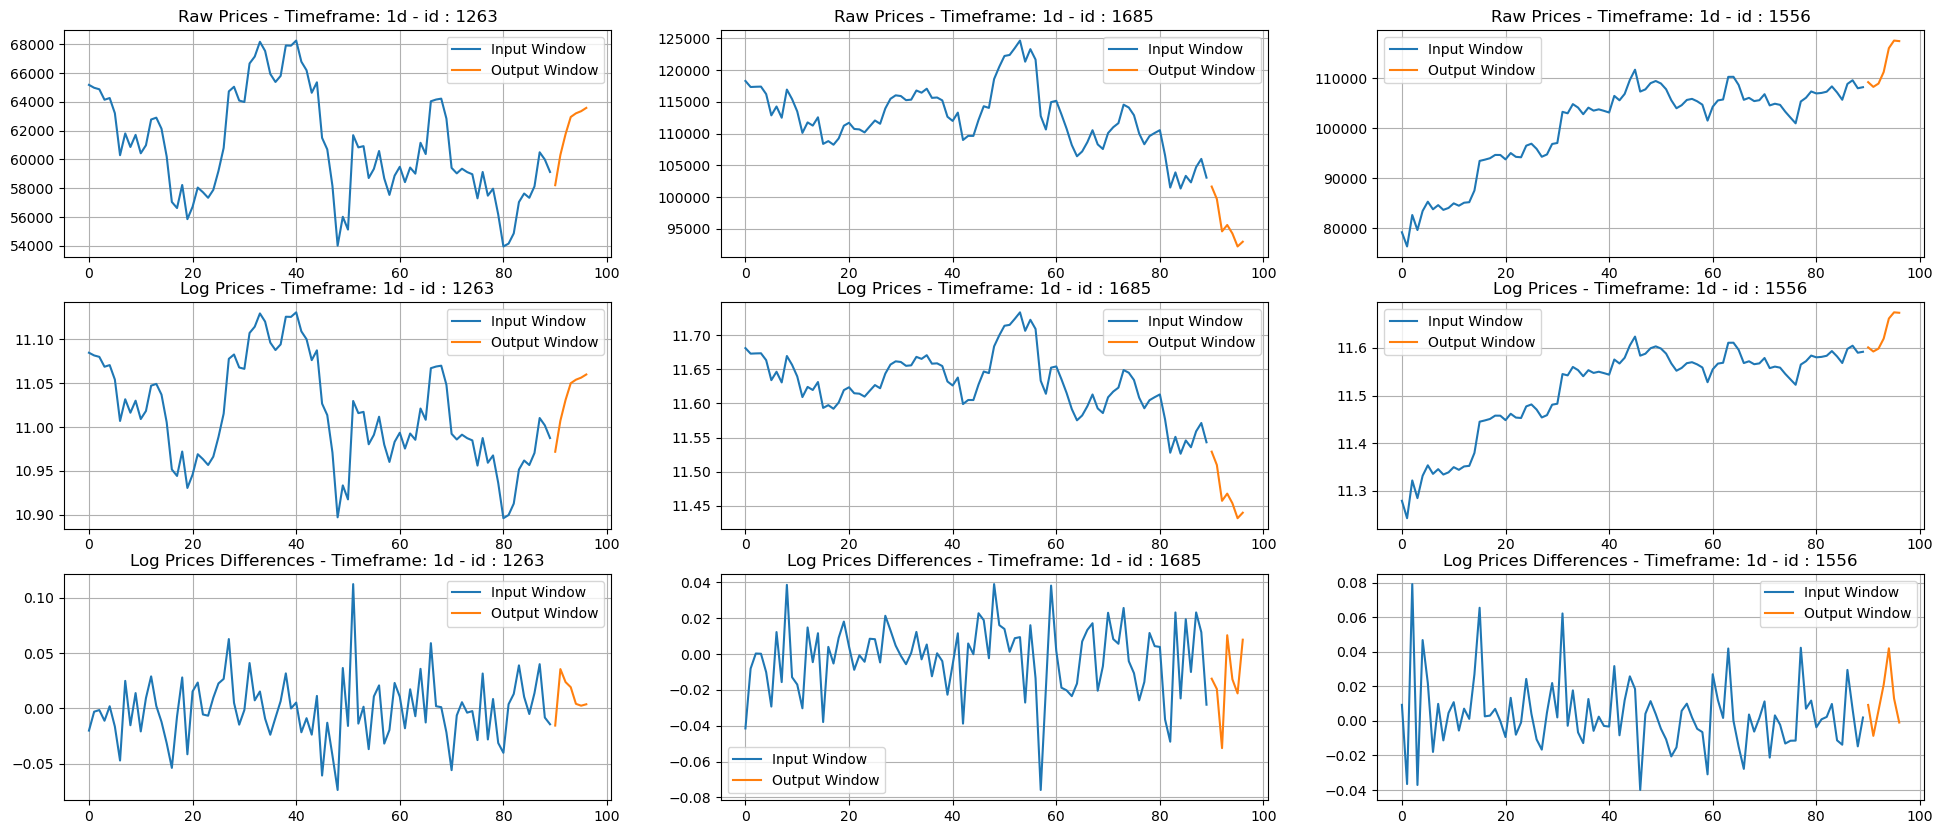

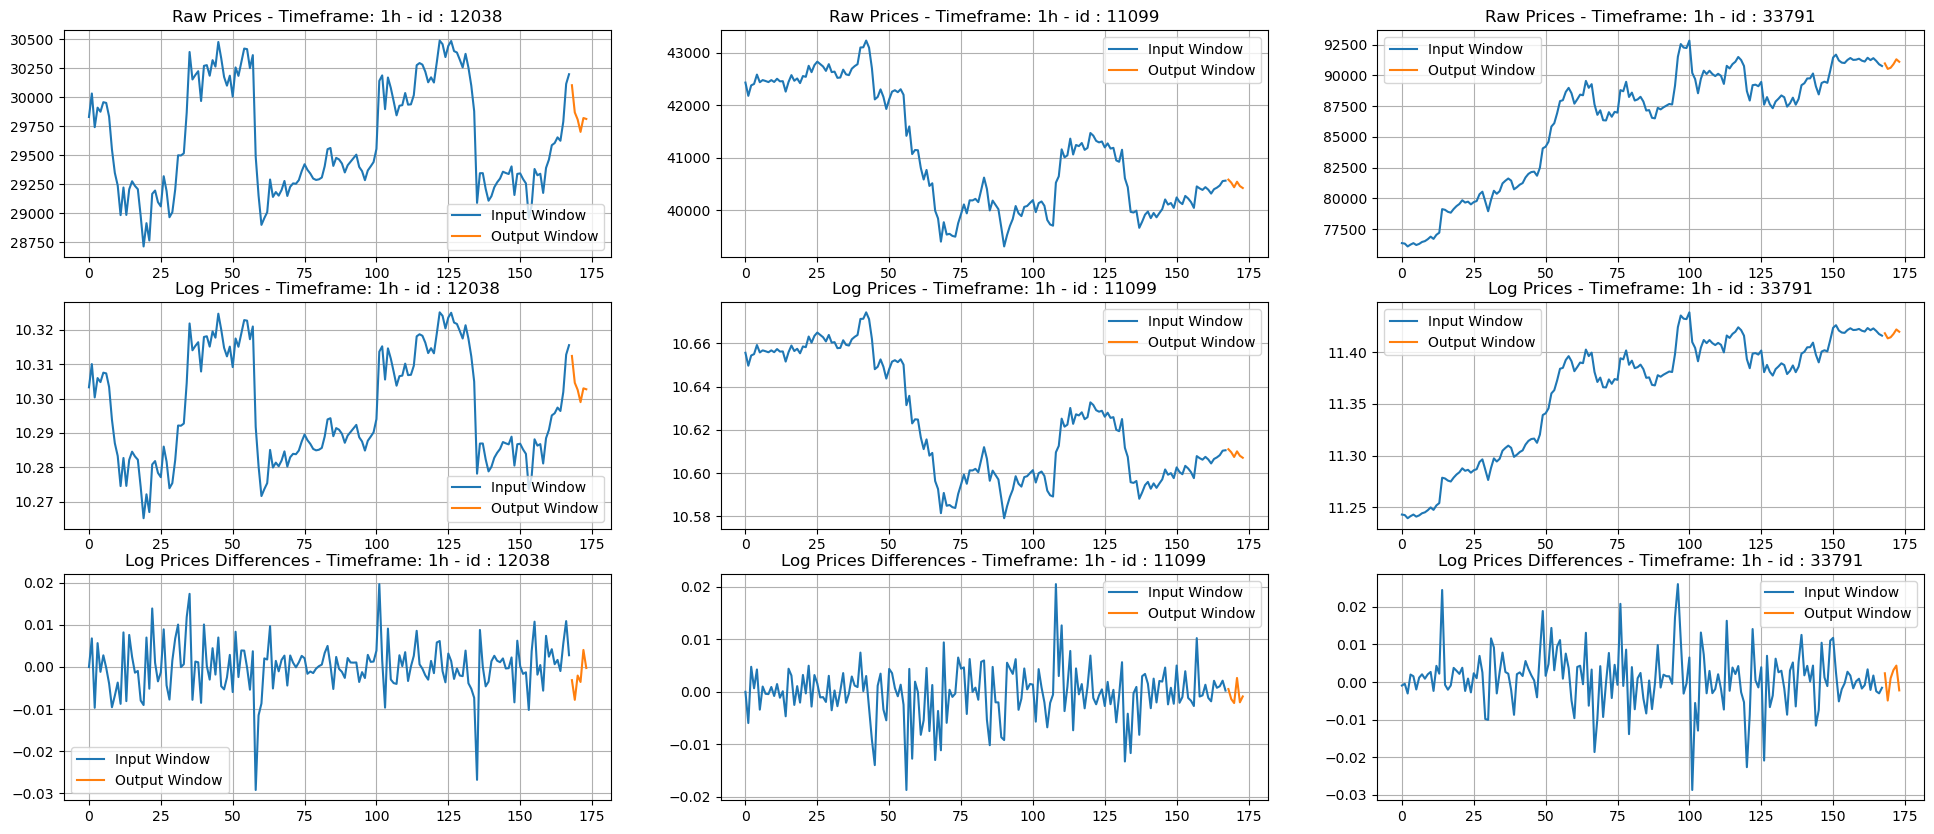

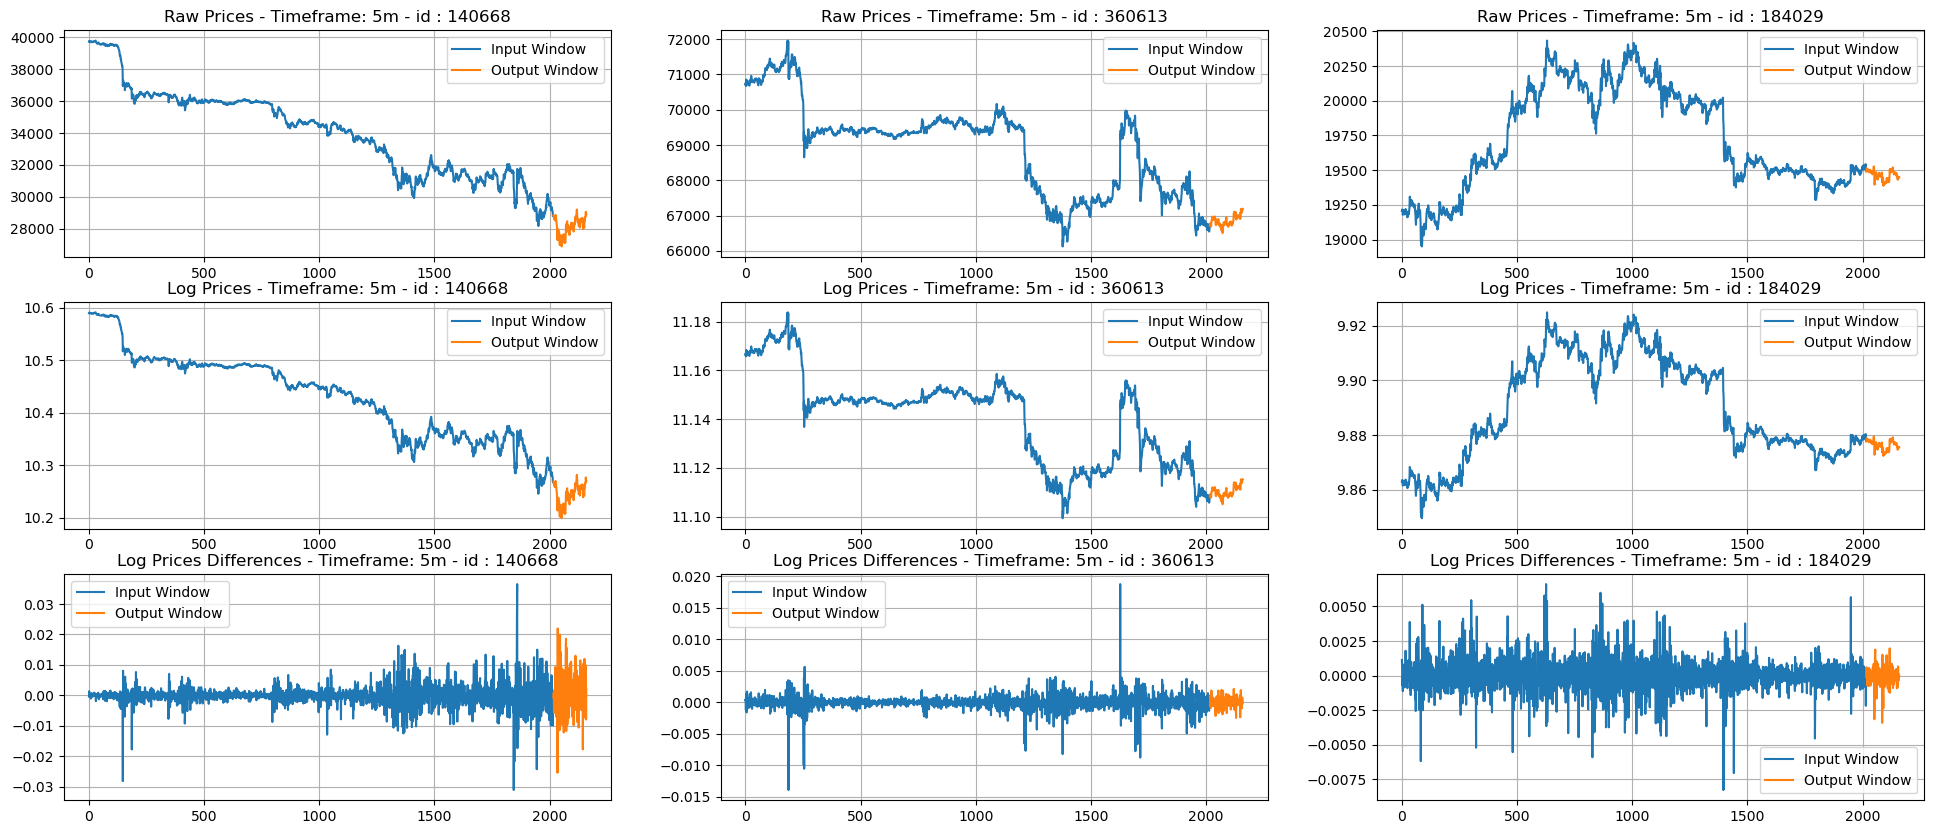

In [159]:
timeframes = ["1d", "1h", "5m"]

for timeframe in timeframes:
    fig, ax = plt.subplots(nrows=3, ncols =3, figsize=(24, 10))
    X, Y = data[timeframe]
    X_logs, Y_logs = data_logs[timeframe]
    X_log_diffs, Y_log_diffs = data_log_diffs[timeframe]

    idx = np.random.choice(len(X), size=3, replace=False)

    for i, id in enumerate(idx):
        # raw prices
        ax[0,i].plot(X[id], label='Input Window')
        ax[0,i].plot(range(len(X[id]), len(X[id]) + len(Y[id])), Y[id], label='Output Window')
        ax[0,i].set_title(f'Raw Prices - Timeframe: {timeframe} - id : {id}')
        ax[0,i].grid()
        ax[0,i].legend()
        # log prices
        ax[1,i].plot(X_logs[id], label='Input Window')
        ax[1,i].plot(range(len(X_logs[id]), len(X_logs[id]) + len(Y_logs[id])), Y_logs[id], label='Output Window')
        ax[1,i].set_title(f'Log Prices - Timeframe: {timeframe} - id : {id}')
        ax[1,i].grid()
        ax[1,i].legend()
        # log diff prices
        ax[2,i].plot(X_log_diffs[id], label='Input Window')
        ax[2,i].plot(range(len(X_log_diffs[id]), len(X_log_diffs[id]) + len(Y_log_diffs[id])), Y_log_diffs[id], label='Output Window')
        ax[2,i].set_title(f'Log Prices Differences - Timeframe: {timeframe} - id : {id}')
        ax[2,i].grid()
        ax[2,i].legend()
        
    plt.show()

# ARIMA on log Prices

### Picking a Log Prices time series at random

In [161]:
# Picking an example time series

timeframe = "5m"  # pick a time frame among "1d", "1h", "5m"
X_logs, Y_logs = data_logs[timeframe]
id = np.random.choice(len(X_logs))

X = X_logs[id]
Y = Y_logs[id]

In [162]:
# Toy example

# t = np.linspace(0, 100, 550)
# X = np.sin(0.2 * t) + 0.05 * np.random.normal(size=len(t))
# Y = X[500:]
# X = X[:500]

# id = 0  # dummy id for consistency

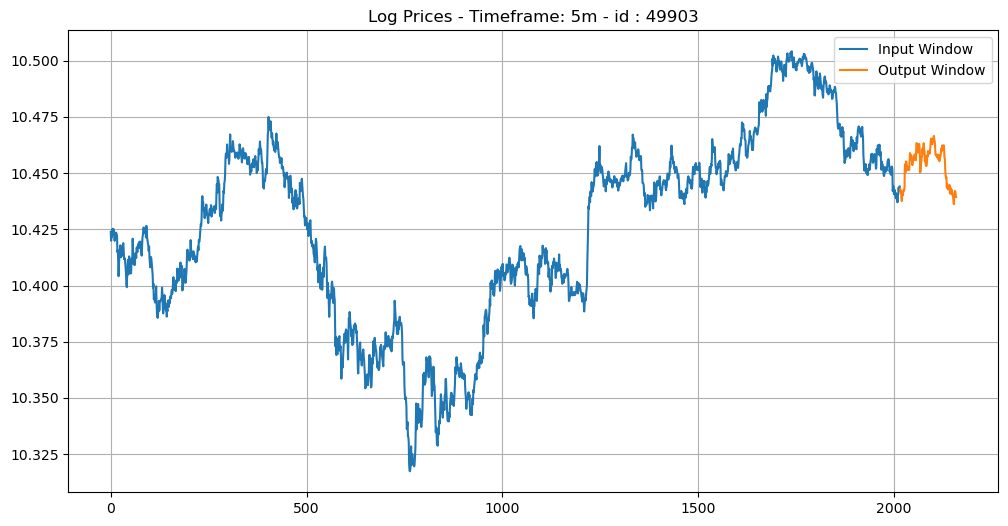

In [163]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(X, label='Input Window')
ax.plot(range(len(X), len(X) + len(Y)), Y, label='Output Window')
ax.set_title(f'Log Prices - Timeframe: {timeframe} - id : {id}')
ax.grid()
ax.legend()
plt.show()

### Checking that the Log Prices series is NOT stationary

In [164]:
result = adfuller(X, maxlag=None, regression='c', autolag='AIC')

adf_stat, pvalue, usedlag, nobs, crit_vals, icbest = result

print('ADF Statistic:', adf_stat)
print('p-value:', pvalue)
print('Used lag:', usedlag)
print('Number of obs:', nobs)
print('Critical Values:', crit_vals)
if icbest is not None:
    print('IC best:', icbest)

# optionally format output
out = pd.Series({
    'adf_stat': adf_stat,
    'pvalue': pvalue,
    'usedlag': usedlag,
    'nobs': nobs,
    'icbest': icbest
})
for k, v in crit_vals.items():
    out[f'cv_{k}'] = v
print(out)

ADF Statistic: -1.510404372290315
p-value: 0.5283583098056773
Used lag: 7
Number of obs: 2008
Critical Values: {'1%': np.float64(-3.433610796445261), '5%': np.float64(-2.8629804474582348), '10%': np.float64(-2.5675368321236967)}
IC best: -17526.3088682686
adf_stat       -1.510404
pvalue          0.528358
usedlag         7.000000
nobs         2008.000000
icbest     -17526.308868
cv_1%          -3.433611
cv_5%          -2.862980
cv_10%         -2.567537
dtype: float64


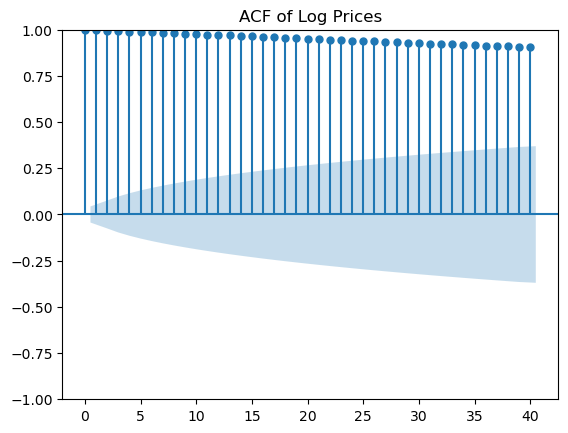

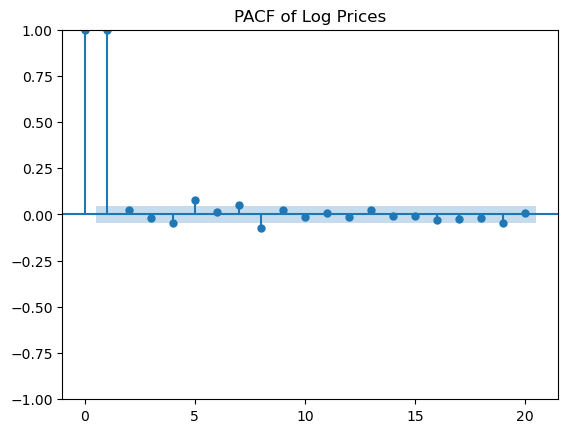

In [165]:
acf_original = plot_acf(X, lags=40, alpha=0.05, title='ACF of Log Prices')
pacf_original = plot_pacf(X, lags=20, alpha=0.05, title='PACF of Log Prices')

### Differenciating and Checking stationarity of log-returns

In [166]:
df_X = pd.DataFrame(X, columns=['log_returns'])
diff = df_X.diff().dropna()

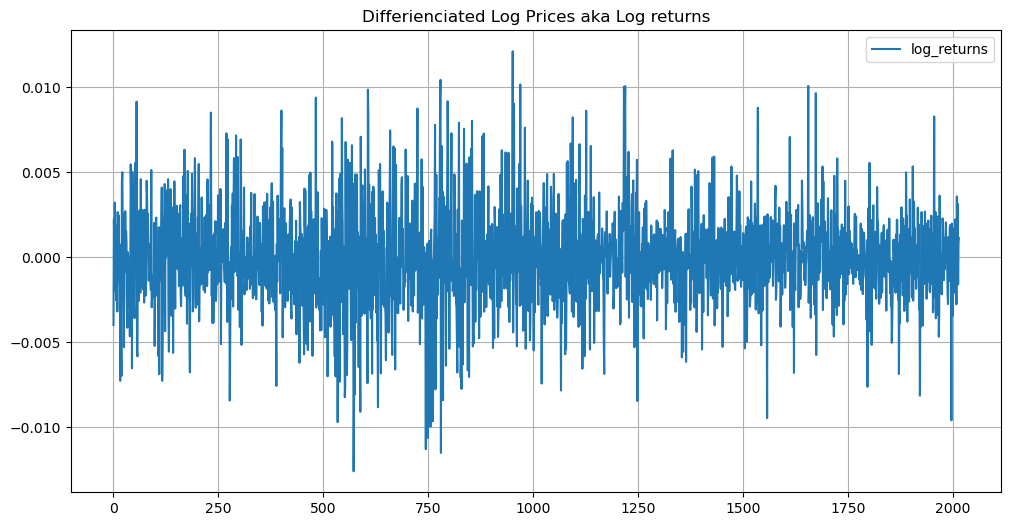

In [167]:
fig, ax = plt.subplots(figsize=(12, 6))
diff.plot(ax=ax, title='Differienciated Log Prices aka Log returns')
ax.grid()
plt.show()

In [168]:
series = diff.values.astype(float)   # e.g., log returns
result = adfuller(series, maxlag=None, regression='c', autolag='AIC')

adf_stat, pvalue, usedlag, nobs, crit_vals, icbest = result

print('ADF Statistic:', adf_stat)
print('p-value:', pvalue)
print('Used lag:', usedlag)
print('Number of obs:', nobs)
print('Critical Values:', crit_vals)
if icbest is not None:
    print('IC best:', icbest)

# optionally format output
out = pd.Series({
    'adf_stat': adf_stat,
    'pvalue': pvalue,
    'usedlag': usedlag,
    'nobs': nobs,
    'icbest': icbest
})
for k, v in crit_vals.items():
    out[f'cv_{k}'] = v
print(out)

ADF Statistic: -16.951405915448788
p-value: 9.455213719810536e-30
Used lag: 6
Number of obs: 2008
Critical Values: {'1%': np.float64(-3.433610796445261), '5%': np.float64(-2.8629804474582348), '10%': np.float64(-2.5675368321236967)}
IC best: -17516.65569546136
adf_stat   -1.695141e+01
pvalue      9.455214e-30
usedlag     6.000000e+00
nobs        2.008000e+03
icbest     -1.751666e+04
cv_1%      -3.433611e+00
cv_5%      -2.862980e+00
cv_10%     -2.567537e+00
dtype: float64


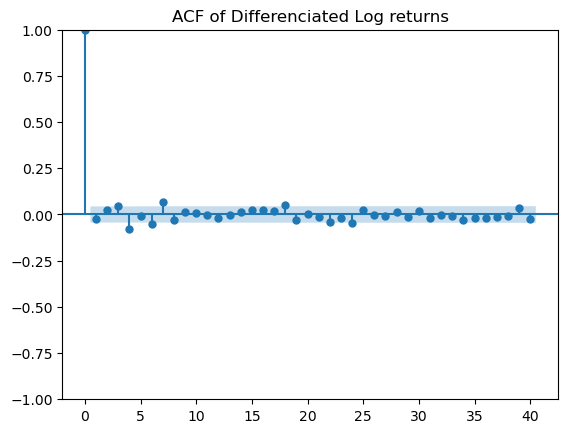

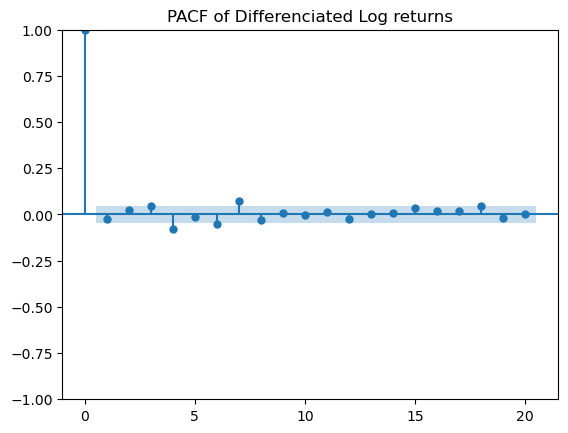

In [169]:
acf_original = plot_acf(diff, lags=40, title='ACF of Differenciated Log returns')
pacf_original = plot_pacf(diff, lags=20, title='PACF of Differenciated Log returns')

### Parameters : manual choice
- d=1 (differenciating once is enough)
- p=8
- q=0

In [170]:
manual_model = ARIMA(X, order=(8,1,2))
manual_model_fit = manual_model.fit()
print(manual_model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 2016
Model:                 ARIMA(8, 1, 2)   Log Likelihood                8884.596
Date:                Thu, 27 Nov 2025   AIC                         -17747.192
Time:                        19:30:28   BIC                         -17685.500
Sample:                             0   HQIC                        -17724.549
                               - 2016                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0091      1.974     -0.005      0.996      -3.877       3.859
ar.L2          0.0105      0.729      0.014      0.988      -1.418       1.439
ar.L3          0.0510      0.035      1.443      0.1

### Checking residuals...

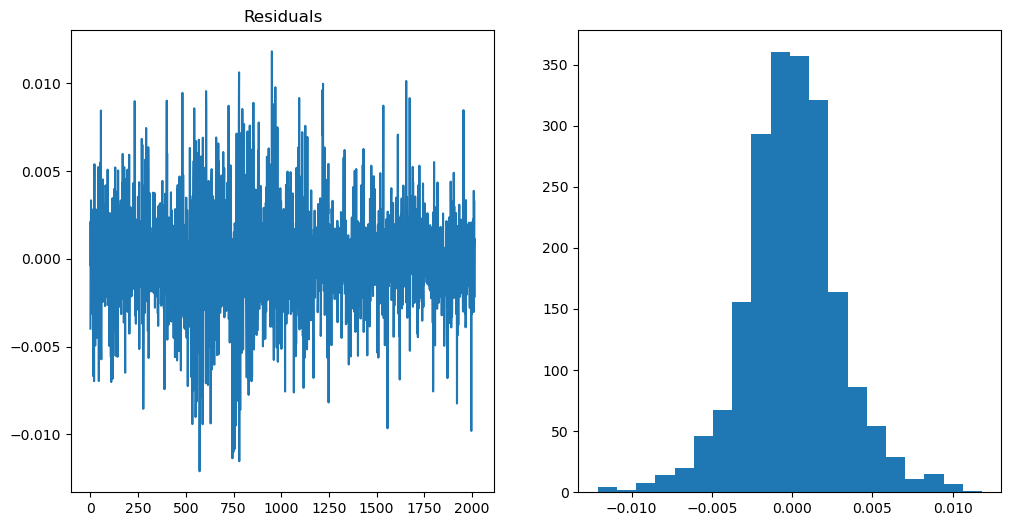

In [171]:
residuals = manual_model_fit.resid[1:]  # skip first NaN value
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
ax[0].plot(residuals)
ax[0].set_title("Residuals")
ax[1].hist(residuals, bins=20)
plt.show()

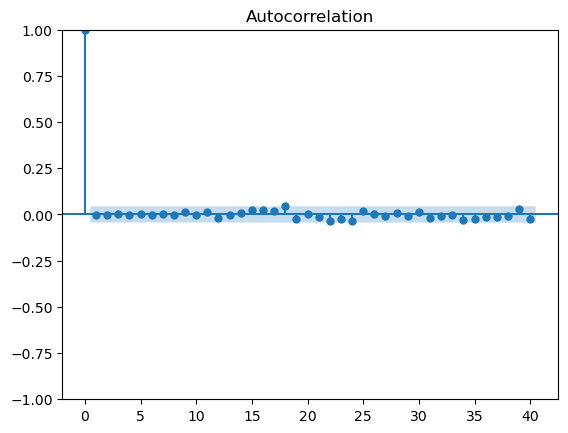

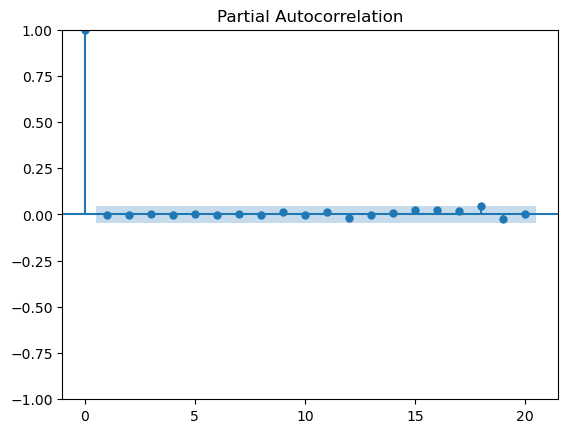

In [172]:
acf_resid = plot_acf(residuals, lags=40)
pacf_resid = plot_pacf(residuals, lags=20)

### Making predictions

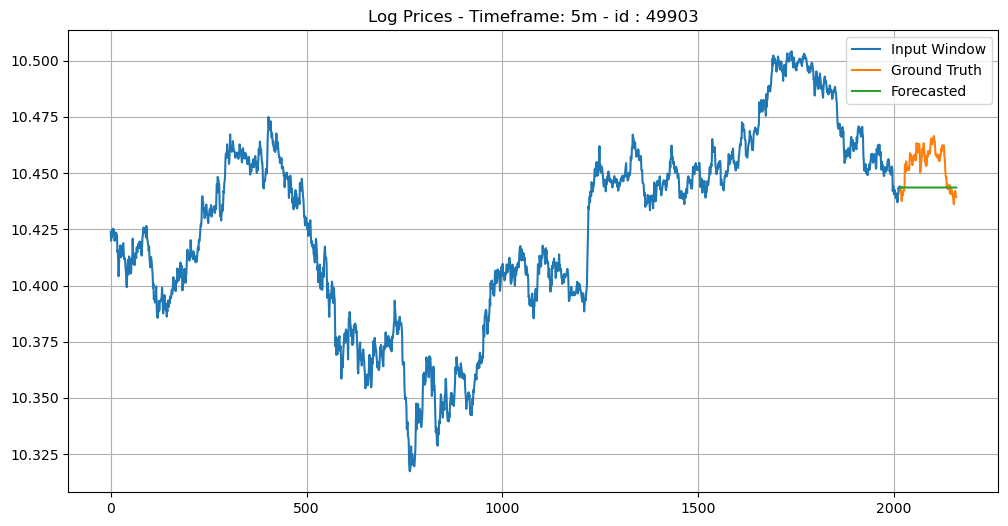

In [173]:
manual_forecast = manual_model_fit.forecast(steps=len(Y))

fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(X, label='Input Window')
ax.plot(range(len(X), len(X) + len(Y)), Y, label='Ground Truth')
ax.plot(range(len(X), len(X) + len(manual_forecast)), manual_forecast, label='Forecasted')
ax.set_title(f'Log Prices - Timeframe: {timeframe} - id : {id}')
ax.grid()
ax.legend()
plt.show()

### Using AIC criterion to find optimal parameters

In [174]:
import pmdarima as pm
auto_model = pm.auto_arima(X, seasonal=True, stepwise=True)
print(auto_model.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 2016
Model:               SARIMAX(0, 1, 0)   Log Likelihood                8866.194
Date:                Thu, 27 Nov 2025   AIC                         -17730.388
Time:                        19:30:46   BIC                         -17724.779
Sample:                             0   HQIC                        -17728.329
                               - 2016                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      8.819e-06   2.17e-07     40.613      0.000    8.39e-06    9.24e-06
Ljung-Box (L1) (Q):                   1.23   Jarque-Bera (JB):               136.14
Prob(Q):                              0.27   Pr

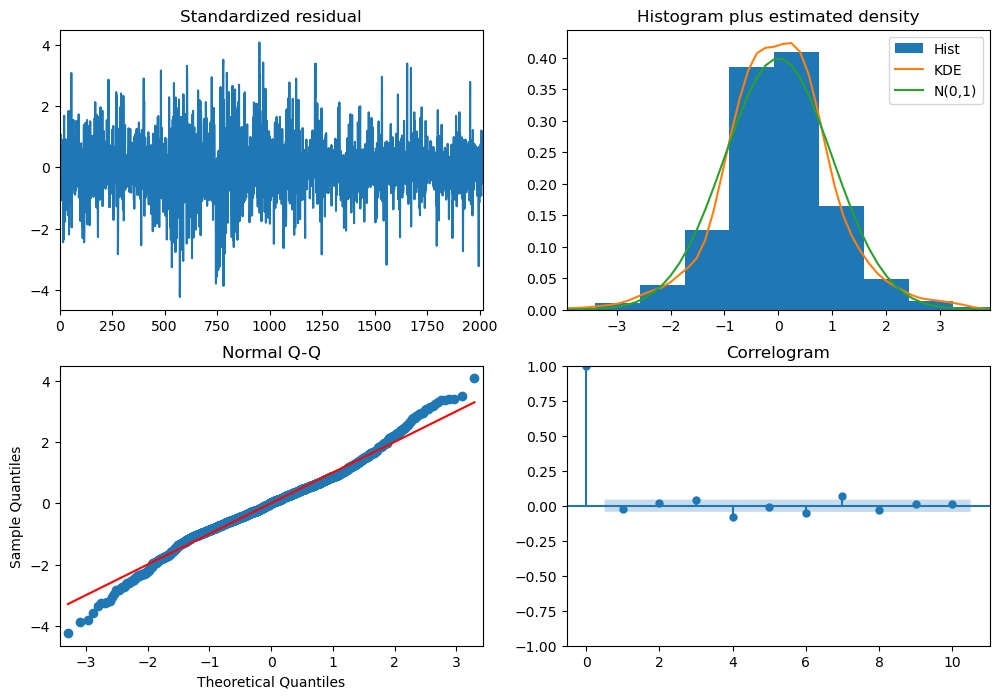

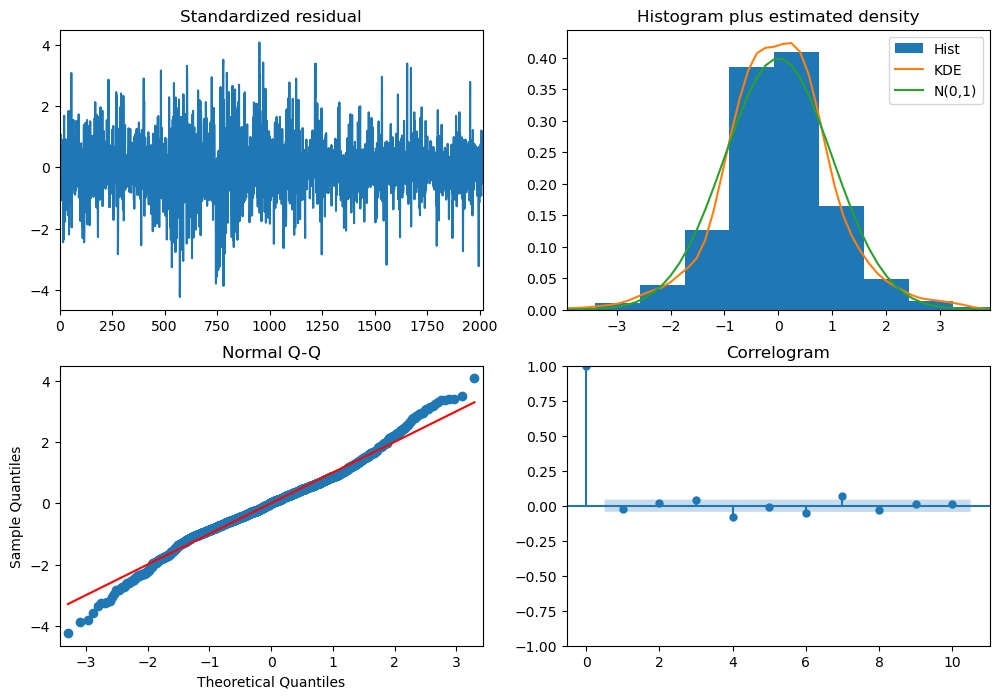

In [175]:
auto_model.plot_diagnostics(figsize=(12,8))

In [176]:
auto_model = ARIMA(X, order=(0,1,0))
auto_model_fit = auto_model.fit()
print(auto_model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 2016
Model:                 ARIMA(0, 1, 0)   Log Likelihood                8866.194
Date:                Thu, 27 Nov 2025   AIC                         -17730.388
Time:                        19:30:59   BIC                         -17724.779
Sample:                             0   HQIC                        -17728.329
                               - 2016                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      8.819e-06   2.17e-07     40.613      0.000    8.39e-06    9.24e-06
Ljung-Box (L1) (Q):                   1.23   Jarque-Bera (JB):               136.14
Prob(Q):                              0.27   Pr

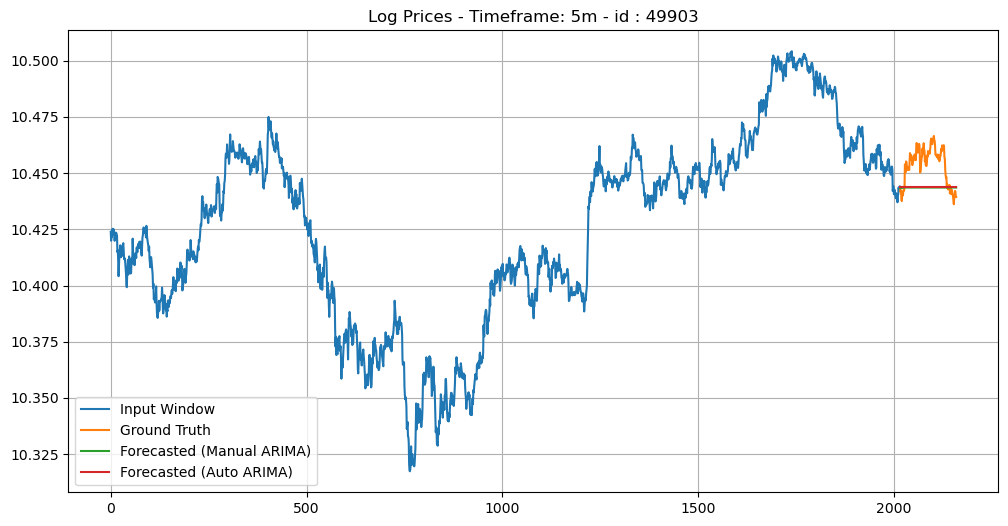

In [177]:
auto_forecast = auto_model_fit.forecast(steps=len(Y))

fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(X, label='Input Window')
ax.plot(range(len(X), len(X) + len(Y)), Y, label='Ground Truth')
ax.plot(range(len(X), len(X) + len(manual_forecast)), manual_forecast, label='Forecasted (Manual ARIMA)')
ax.plot(range(len(X), len(X) + len(auto_forecast)), auto_forecast, label='Forecasted (Auto ARIMA)')
ax.set_title(f'Log Prices - Timeframe: {timeframe} - id : {id}')
ax.grid()
ax.legend()
plt.show()

### Metrics to compare models

In [178]:
mae = np.mean(np.abs(auto_forecast - Y))
print(f'Mean Absolute Error (Auto ARIMA): {mae:.3e}')
mae_manual = np.mean(np.abs(manual_forecast - Y))
print(f'Mean Absolute Error (Manual ARIMA): {mae_manual:.3e}')

mse = np.mean((auto_forecast - Y)**2)
print(f'Mean Squared Error (Auto ARIMA): {mse:.3e}')
mse_manual = np.mean((manual_forecast - Y)**2)
print(f'Mean Squared Error (Manual ARIMA): {mse_manual:.3e}')

Mean Absolute Error (Auto ARIMA): 1.092e-02
Mean Absolute Error (Manual ARIMA): 1.116e-02
Mean Squared Error (Auto ARIMA): 1.567e-04
Mean Squared Error (Manual ARIMA): 1.652e-04
